In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/guitarsounds')
%load_ext autoreload

In [2]:
%autoreload 2
from guitarsounds import Sound, Signal
import guitarsounds as guit

In [3]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, make_interp_spline
from scipy.optimize import least_squares
import pandas as pd

# Developping time damping analysis

## Get a time signal

In [4]:
# Get a signal to test
sound = Sound('soundfiles/flax_carbon/Wood_D0_2.wav')
sound.condition()

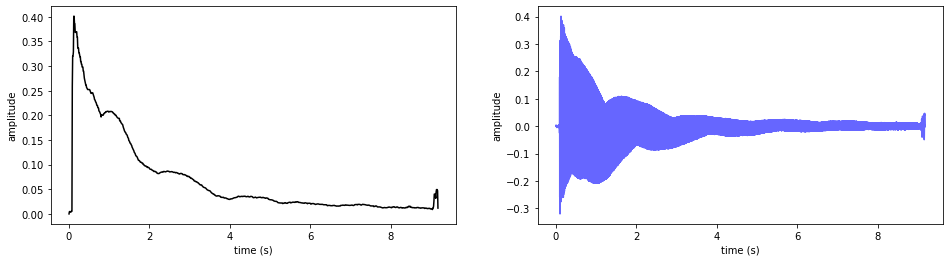

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

plt.sca(ax1)
sound.signal.plot('envelop', c='k')

plt.sca(ax2)
sound.signal.plot('signal', c='b')

## Time dependent damping of signals

For a sinusoidal signal : $s = sin(wt)$

The damped signal will follow the following shape :

$$ s = sin(\omega t) \; e^{-\zeta \omega_d t} $$

with $\zeta$ the damping ratio.

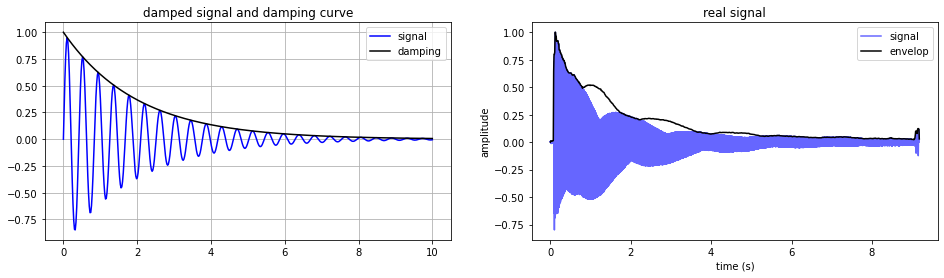

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# Create a signal
t = np.linspace(0, 10, 500)
w = 15
zeta = 0.5
s = np.sin(w*t)*np.exp(-zeta*t)
e = np.exp(-zeta*t)

# Plot the created signal
plt.sca(ax1)
plt.plot(t,s, label='signal', c='b')
plt.plot(t,e, label='damping', c='k')
plt.legend()
plt.grid('on')
plt.title('damped signal and damping curve')

# Plot the real signal
plt.sca(ax2)
sound.signal.normalize().plot('signal', c='b', label='signal')
sound.signal.normalize().plot('envelop', c='k', label='envelop')
plt.title('real signal')
plt.legend()

plt.show()

## Finding the $\zeta$ value from the real signal envelop

**Getting the data from wich $\zeta$ is derived**

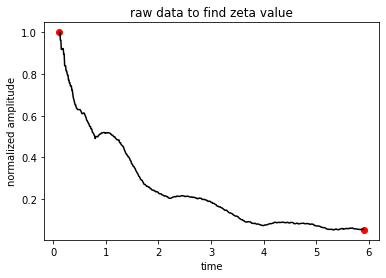

In [7]:
# getting the vectors
envelop = sound.signal.normalize().envelop()
envelop_time = sound.signal.normalize().envelop_time()

# First point is the maximum because e^-kt is stricly decreasing
first_index = np.argmax(envelop)
first_point = (envelop_time[first_index], np.max(envelop))

# The second point is the first point where the signal crosses the 0.05 line
second_point_thresh = 0.05
second_index = np.flatnonzero(envelop[first_index:]<=second_point_thresh)[0]
second_point = (envelop_time[second_index], envelop[second_index])

# Plotting
plt.plot(envelop_time[first_index:second_index], envelop[first_index:second_index], c='k')
plt.scatter(*first_point, color='r')
plt.scatter(*second_point, color='r')
plt.title('raw data to find zeta value')
plt.xlabel('time')
plt.ylabel('normalized amplitude')
plt.show()

## Least square curve fitting

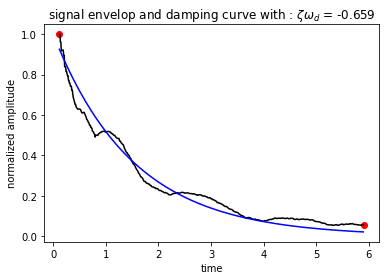

In [8]:
# Fit a single parameter negative exponential to the signal
def residual_function(zeta, t, s):
    return np.exp(zeta[0]*t) - s

zeta_guess = [-0.5]

result = least_squares(residual_function, zeta_guess, args = (envelop_time[first_index:second_index], envelop[first_index:second_index]))

zeta_omega = result.x

wd = 2*np.pi*sound.signal.fundamental()
zeta = zeta_omega/wd

# Plotting the fitted curve
plt.plot(envelop_time[first_index:second_index], envelop[first_index:second_index], c='k')
plt.scatter(*first_point, color='r')
plt.scatter(*second_point, color='r')
plt.plot(envelop_time[first_index:second_index], np.exp(zeta_omega*envelop_time[first_index:second_index]), c='b')
plt.title(r'signal envelop and damping curve with : $\zeta \omega_d$ = ' + str(np.around(zeta_omega[0],3)))
plt.xlabel('time')
plt.ylabel('normalized amplitude')
plt.show()

## Finding the $\omega_d$ value

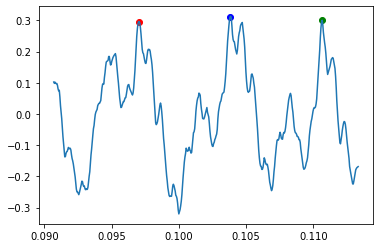

Period T1 :  0.0068
Period T2 :  0.00685
Frequency f1 :  147.00000000000014
Frequency f2 :  146.02649006622505
Fundamental from FFT :  145.9051660188125


In [9]:
plt.plot(sound.signal.time()[2000:2500], sound.signal.signal[2000:2500])

index1 = np.argmax(sound.signal.signal[2000:2200])+2000
point1 = (sound.signal.time()[index1], sound.signal.signal[index1])

index2 = np.argmax(sound.signal.signal[2100:2300])+2099
point2 = (sound.signal.time()[index2], sound.signal.signal[index2])

index3 = np.argmax(sound.signal.signal[2400:2500])+2400
point3 = (sound.signal.time()[index3], sound.signal.signal[index3])

plt.scatter(*point1, c='r')
plt.scatter(*point2, c='b')
plt.scatter(*point3, c='g')

plt.show()
T1 = sound.signal.time()[index2] - sound.signal.time()[index1]
T2 = sound.signal.time()[index3] - sound.signal.time()[index2]

print('Period T1 : ', np.around(T1, 5))
print('Period T2 : ', np.around(T2, 5))
print('Frequency f1 : ', 1/T1)
print('Frequency f2 : ', 1/T2)
print('Fundamental from FFT : ', sound.signal.fundamental())

$\omega_d = 2\pi f = 917 \; rad/s $

$ \zeta = -0.65878108/917 = 0.000718$

In [10]:
sound.signal.peak_damping()

array([0.00058204, 0.00043162, 0.00033387, 0.00045299, 0.00028553,
       0.00034149, 0.00046517, 0.00038852, 0.00040578, 0.0002906 ,
       0.00027202, 0.00044698, 0.00062005])

## Implementation

In [11]:
sound.signal.time_damping()

0.000718605576843721

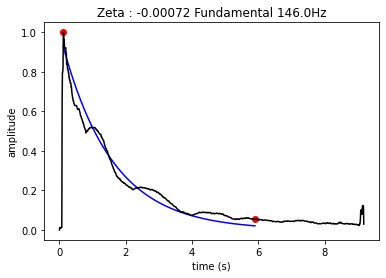

In [12]:
sound.signal.plot('time damping')

## Testing

### 1. Working with different fundamentals

,damping,fundamental
2,0.001053,81.986923
4,0.001392,82.230902
0,0.001062,109.656636
3,0.000719,145.905166
1,0.000468,146.512900
5,0.000324,328.654315


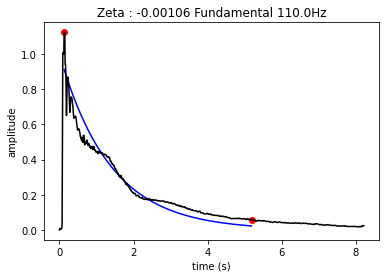

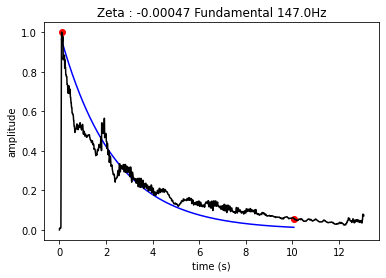

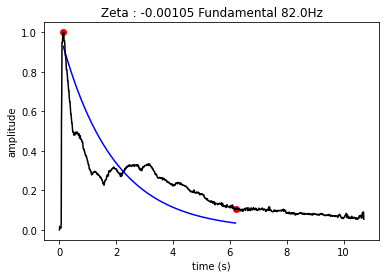

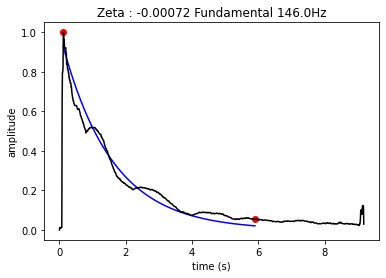

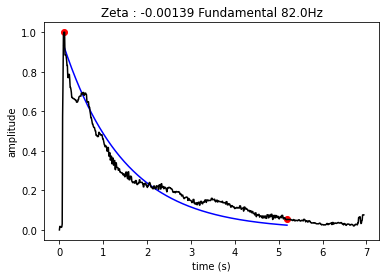

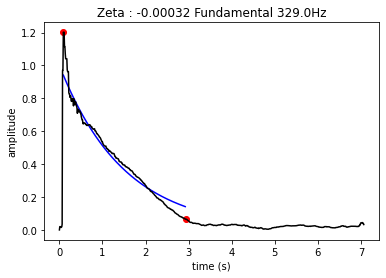

In [13]:
file1 = 'soundfiles/flax_carbon/Wood_A0_1.wav'
file2 = 'soundfiles/flax_carbon/Carbon_D0_2.wav'
file3 = 'soundfiles/flax_carbon/Carbon_E0_1.wav'
file4 = 'soundfiles/flax_carbon/Wood_D0_2.wav'
file5 = 'soundfiles/flax_carbon/Wood_E0_1.wav'
file6 = 'soundfiles/flax_carbon/Wood_E1_1.wav'
files = [file1, file2, file3, file4, file5, file6]

sounds = [Sound(file).condition(return_self=True) for file in files]

zetas = []
fundamentals = []

for sound in sounds:
    zetas.append(sound.signal.time_damping())
    fundamentals.append(sound.signal.fundamental())
    plt.figure()
    sound.signal.plot('time damping')

pd.DataFrame(np.array([zetas, fundamentals]).transpose(), columns=['damping', 'fundamental']).sort_values('fundamental')

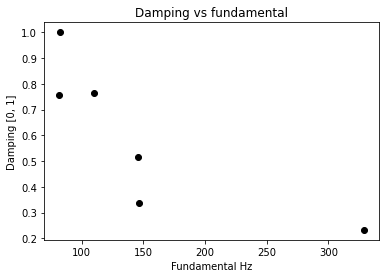

In [14]:
plt.scatter(fundamentals, np.array(zetas)/np.array(zetas).max(), color='k')
plt.title('Damping vs fundamental')
plt.xlabel('Fundamental Hz')
plt.ylabel('Damping [0, 1]')
plt.show()

### 2. Comparing two materials

In [26]:
carbonfile = 'soundfiles/flax_carbon/Carbon_D0_2.wav'
woodfile = 'soundfiles/flax_carbon/Wood_D0_2.wav'

carbon = Sound(carbonfile, name='carbon').condition(return_self=True)
wood = Sound(woodfile, name='wood').condition(return_self=True)

print('carbon : ', carbon.signal.time_damping())
print('wood : ', wood.signal.time_damping())

carbon :  0.0004679785370889061
wood :  0.000718605576843721


### 3. Works for plates ?

In [22]:
carbonfile = 'soundfiles/flax_carbon/Carbon.wav'
flaxfile = 'soundfiles/flax_carbon/Flax.wav'

carbon = Sound(carbonfile, name='carbon').condition(return_self=True)
flax = Sound(flaxfile, name='flax').condition(return_self=True)

print('carbon : ', carbon.signal.time_damping())
print('wood : ', flax.signal.time_damping())

carbon :  0.004366869439672067
wood :  0.001956143295141682


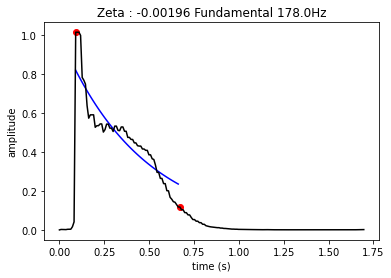

In [23]:
flax.signal.plot('time damping')

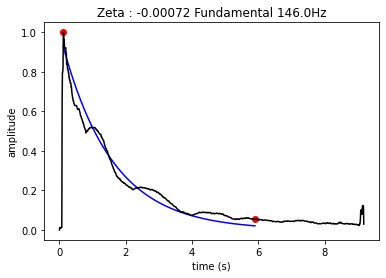

In [18]:
wood.signal.plot('time damping')

0.0061398317282924135
0.0006073523649603639
0.0003157279329472644


/Users/Olivier/anaconda3/envs/guitarsounds/guitarsounds.py:628: RuntimeWarning: invalid value encountered in log10
  min_height = 10 ** np.linspace(np.log10(fft_max_start + diff_start), np.log10(fft_max_end), max_index)


0.00021082409869256874


/Users/Olivier/anaconda3/envs/guitarsounds/guitarsounds.py:628: RuntimeWarning: invalid value encountered in log10
  min_height = 10 ** np.linspace(np.log10(fft_max_start + diff_start), np.log10(fft_max_end), max_index)


0.00017037339315437345


/Users/Olivier/anaconda3/envs/guitarsounds/guitarsounds.py:628: RuntimeWarning: invalid value encountered in log10
  min_height = 10 ** np.linspace(np.log10(fft_max_start + diff_start), np.log10(fft_max_end), max_index)


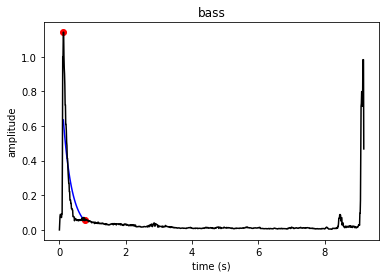

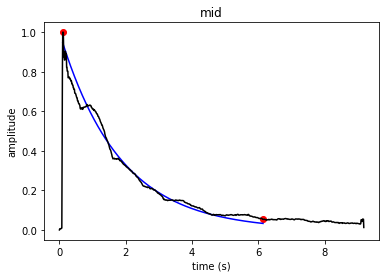

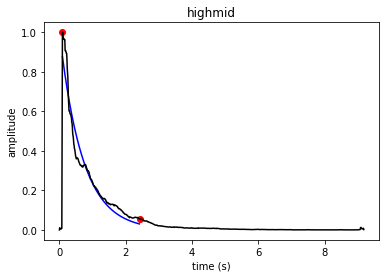

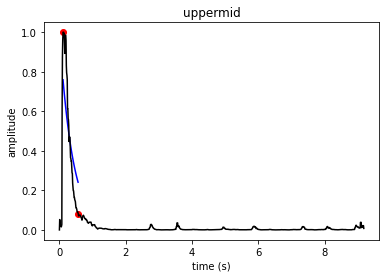

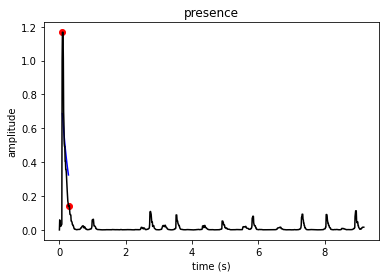

In [42]:
# TODO: Regarder pour faire mieux marcher et comparer deux sons
# TODO: Comparer avec le peak damping

wood.SP.change('fft_range', 5000)

for name, fbin in zip(wood.bins.keys(), wood.bins.values()):
    try:
        print(fbin.time_damping())
        plt.figure()
        fbin.plot('time damping')
        plt.title(name)
    except:
        pass